<newline>.
<newline>
<center>
    <b>
        <font size="12">
            Child mortality prediction
        </font>
    </b>
</center>

# Table of Contents:
* [Problem formulation](#problem-formulation)
* [Data preprocessing](#data-preprocessing)

## Imports

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pmdarima as pm
from typing import List
import warnings
warnings.filterwarnings('ignore')

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

## Functions

In [2]:
def plot_global_map(df:pd.DataFrame, year:int, continents: List[str] = list(set(countries.continent)), ax=None):
    year = "{}".format(year)
    title = get_dataframe_name(df) + " " + year
    df = countries[countries['continent'].isin(continents)].set_index('name').join(df.set_index('country'))
    plot_global_map_figure(df=df, year=year, title=title, ax=ax)
    
def plot_global_map_figure(df: pd.DataFrame, year: str, title: str, ax):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 6))
    
    df.plot(column=year, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(title)
    if ax is None:
        vmin = df[year].min()
        vmax = df[year].max()
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        plt.tight_layout()
        plt.colorbar(sm)

def plot_global_map_subplot(df_list: List[pd.DataFrame], year: int, continents: List[str] = list(set(countries.continent))):
    n_plots = len(df_list)
    fig, axes = plt.subplots(nrows=n_plots, ncols=1, figsize=(n_plots*5, 20))
    
    for i, df in enumerate(df_list):
        plot_global_map(df=df, year=year, ax=axes[i])
    
    plt.tight_layout()
    plt.show()
    
def get_dataframe_name(df: pd.DataFrame):
    for name, obj in globals().items():
        if obj is df:
            return name

# <a id='problem-formulation'></a> Problem formulation 
    
    The problem involves predicting child mortality based on factors from multiple domains of life. In this context, a dataset has been selected that contains information on various factors that potentially influence child mortality. The goal is to develop a predictive model that can estimate the risk of death in children based on these factors.

## Data source:

    The data has been obtained from the Gapminder website [https://www.gapminder.org/data/]. Gapminder is a non-profit organization that collects and provides a wide range of global development data. They offer a comprehensive database that covers various indicators related to population, health, education, economy, and more. The data provided by Gapminder is widely used for research, analysis, and visualizations to gain insights into global trends and patterns.

## Loading data:

In [3]:
original_data = {os.path.splitext(os.path.basename(file_name))[0] : pd.read_csv(file_name) for file_name in glob.glob('original_data/*')}   

# predicted values
child_mortality_df = original_data["child_mortality_0_5_year_olds_dying_per_1000_born"]

# explanatory data
food_supply_df = original_data["food_supply_kilocalories_per_person_and_day"]
med_beds_df = original_data["sh_med_beds_zs"]
co2_emission_df = original_data["co2_emissions_tonnes_per_person"]
gender_equality_df = original_data["gendereq_idea"]

In [4]:
datasets = {
    "child_mortality": "child_mortality_0_5_year_olds_dying_per_1000_born",
    "food_supply_kcal": "food_supply_kilocalories_per_person_and_day",
    "med_beds": "sh_med_beds_zs",
    "co2_emission": "co2_emissions_tonnes_per_person",
    "gender_equality": "gendereq_idea"
}

for dataset_name in datasets:
    dataset_key = datasets[dataset_name]
    print(dataset_name, "\t\033[1m" + original_data[dataset_key].columns[-1] + "\033[0m")

dataset_country_name = [set(original_data[datasets[_]]['country']) for _ in datasets]

child_mortality 	2100
food_supply_kcal 	2018
med_beds 	2019
co2_emission 	2018
gender_equality 	2021


In [5]:
countries_names = dataset_country_name[0].intersection(*dataset_country_name[1:])
print("Number of data intersection countries: ", countries_names.__len__())
print("\n", countries_names)

Number of data intersection countries:  156

 {'Slovenia', 'Kuwait', 'Mozambique', 'Bangladesh', 'Cyprus', 'Lebanon', 'Ghana', 'Vietnam', 'India', 'United States', 'Jamaica', 'Mali', 'France', 'Iraq', 'Togo', 'Suriname', 'Cuba', 'Malta', 'Switzerland', 'Nicaragua', 'Burkina Faso', 'Yemen', 'Finland', 'Russia', 'Cambodia', 'Luxembourg', 'Belgium', 'Ethiopia', 'Trinidad and Tobago', 'Myanmar', 'Central African Republic', 'Peru', 'Cape Verde', 'Lithuania', 'Zimbabwe', 'Botswana', 'Greece', 'Australia', 'Albania', 'Venezuela', 'South Africa', 'Algeria', 'Haiti', 'Mauritania', 'Colombia', 'Georgia', 'Armenia', 'Niger', 'United Arab Emirates', 'Jordan', 'Madagascar', 'North Macedonia', 'Senegal', 'Chile', 'Norway', 'Bosnia and Herzegovina', 'Morocco', 'Mexico', 'Portugal', 'Serbia', 'Kazakhstan', 'Lesotho', 'Turkey', 'Iceland', 'Mauritius', 'Malaysia', 'Ireland', 'Bolivia', 'Tajikistan', 'Egypt', 'Azerbaijan', 'Eswatini', 'Guinea', 'Chad', 'El Salvador', 'Croatia', 'South Korea', 'Kyrgyz Rep

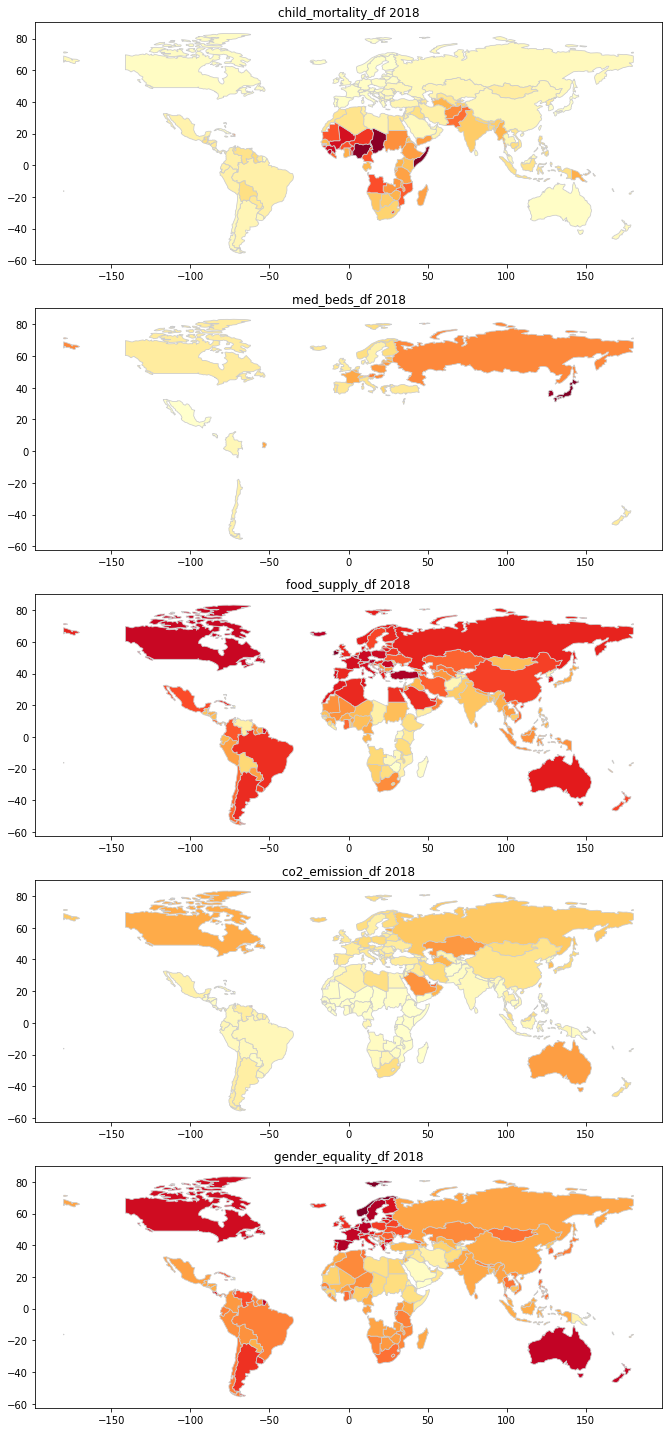

In [6]:
plot_global_map_subplot(df_list=[child_mortality_df, med_beds_df, food_supply_df, co2_emission_df, gender_equality_df], year=2018)

## DAG:
    The selected parameters with the least mutual correlation and the most impact on the target value have been marked with a red border.

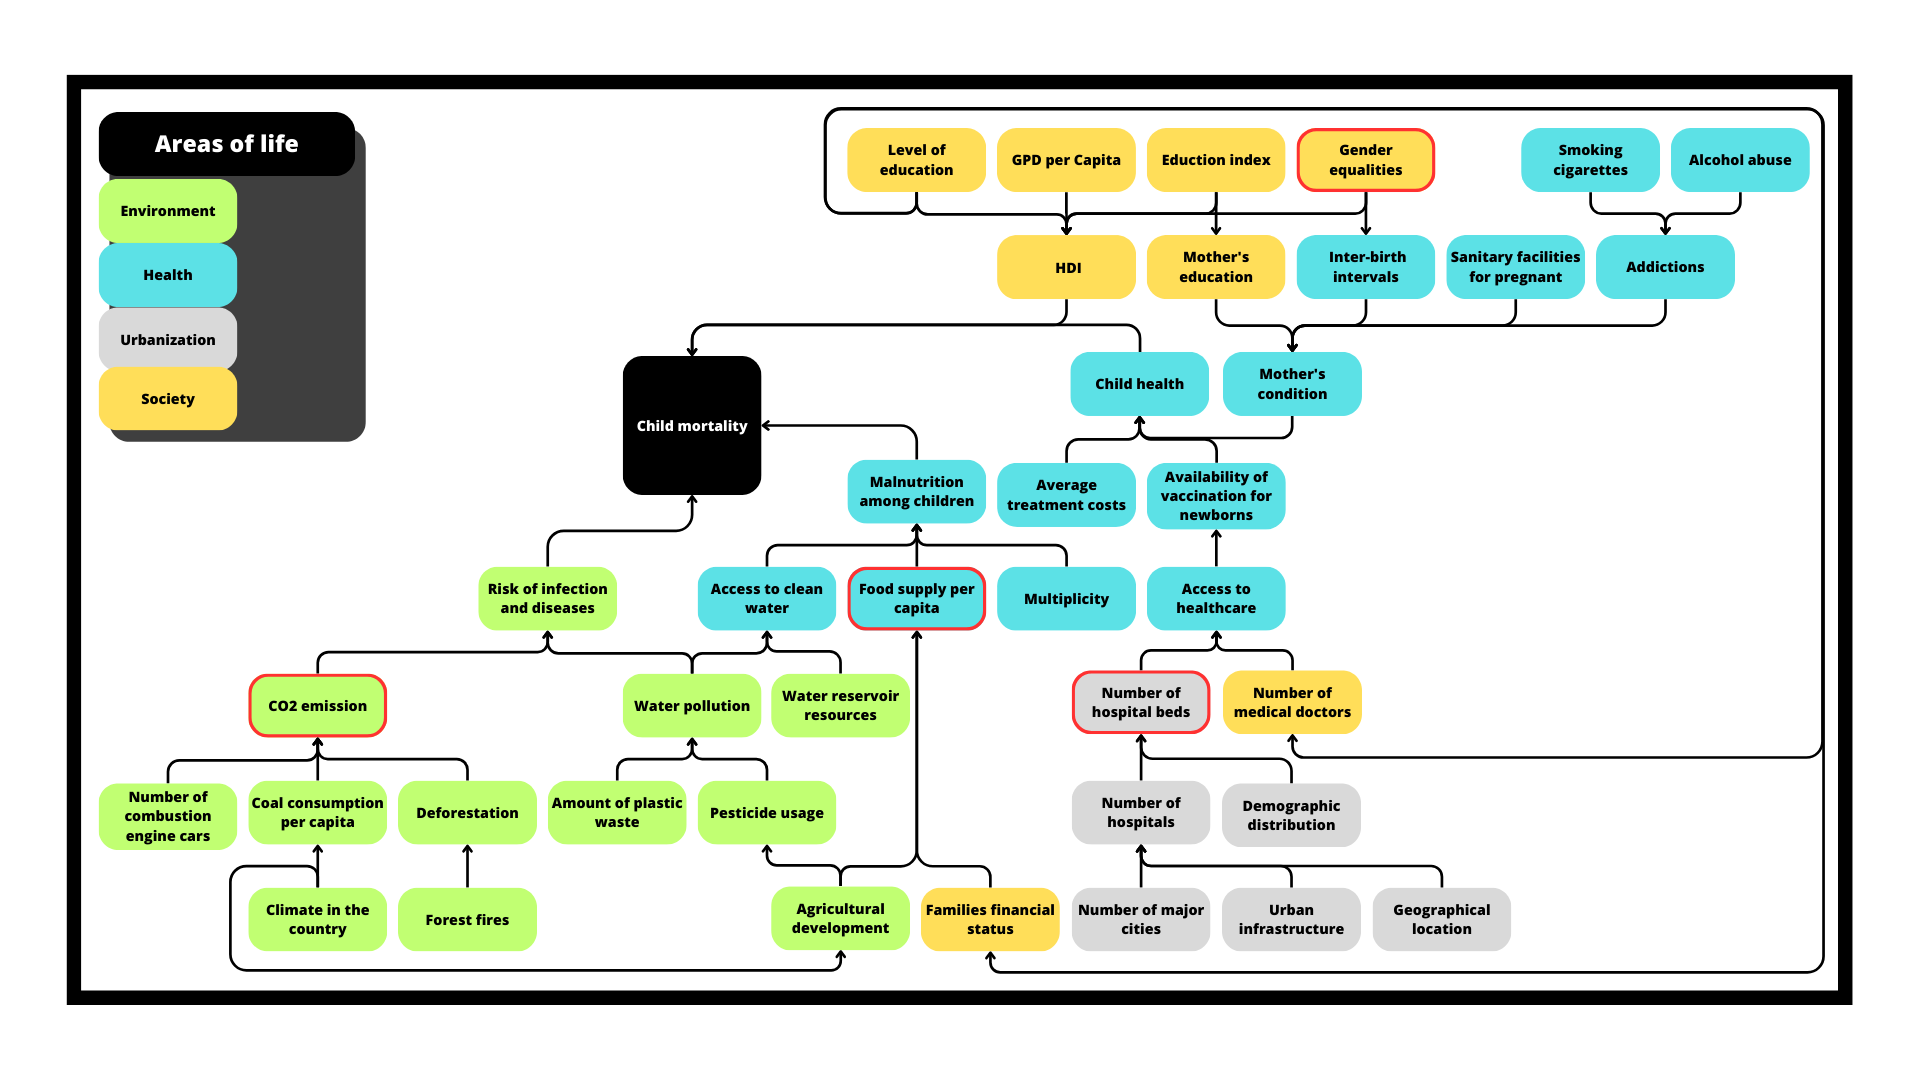

# <a id='data-preprocessing'></a>Data Preprocessing

In [7]:
years_range = [str(i) for i in range(2000, 2020)]

## Data imputation

### child_mortality_0_5_year_olds_dying_per_1000_born

In [8]:
child_mortality_df.columns

Index(['country', '1800', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808',
       ...
       '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099',
       '2100'],
      dtype='object', length=302)

In [9]:
child_mortality_df = child_mortality_df[["country"] + years_range]
child_mortality_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,...,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70,62.30,60.10
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,...,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40,77.20,74.50
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,...,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02,8.82,8.68
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,...,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01,2.89,2.87
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,...,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68,7.59,7.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,21.10,20.40,19.90,19.50,19.20,19.00,18.90,18.90,18.90,...,18.70,18.50,18.30,17.90,17.60,17.20,16.70,16.30,15.80,15.40
193,Yemen,94.90,90.30,85.60,81.10,76.70,72.50,68.40,64.60,61.00,...,56.00,55.10,55.00,55.00,55.00,55.00,55.00,55.00,55.00,54.90
194,South Africa,73.90,75.80,77.40,79.10,79.40,78.50,76.00,71.00,64.80,...,52.50,46.70,43.30,41.20,39.50,37.70,36.60,35.30,33.80,32.90
195,Zambia,162.00,153.00,142.00,130.00,119.00,110.00,101.00,95.40,90.40,...,80.30,77.20,74.30,70.70,66.90,64.60,62.00,59.40,57.80,56.10


In [10]:
child_mortality_df[child_mortality_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019


In [11]:
child_mortality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  197 non-null    object 
 1   2000     197 non-null    float64
 2   2001     197 non-null    float64
 3   2002     197 non-null    float64
 4   2003     197 non-null    float64
 5   2004     197 non-null    float64
 6   2005     197 non-null    float64
 7   2006     197 non-null    float64
 8   2007     197 non-null    float64
 9   2008     197 non-null    float64
 10  2009     197 non-null    float64
 11  2010     197 non-null    float64
 12  2011     197 non-null    float64
 13  2012     197 non-null    float64
 14  2013     197 non-null    float64
 15  2014     197 non-null    float64
 16  2015     197 non-null    float64
 17  2016     197 non-null    float64
 18  2017     197 non-null    float64
 19  2018     197 non-null    float64
 20  2019     197 non-null    float64
dtypes: float64(20), 

### food_supply_kilocalories_per_person_and_day

In [12]:
food_supply_df.columns

Index(['country', '1961', '1962', '1963', '1964', '1965', '1966', '1967',
       '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976',
       '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985',
       '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [13]:
food_supply_df = food_supply_df[["country"] + years_range[:-1]]
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,2080.0,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,2300.0,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,2990.0,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0
3,Netherlands Antilles,3080.0,3050.0,3070.0,3060.0,3080.0,3090.0,3090.0,3070.0,3080.0,3100.0,3110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,3170.0,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,2160.0,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0
175,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,2940.0,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,1880.0,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0


In [14]:
food_supply_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  179 non-null    object 
 1   2000     174 non-null    float64
 2   2001     174 non-null    float64
 3   2002     174 non-null    float64
 4   2003     174 non-null    float64
 5   2004     174 non-null    float64
 6   2005     174 non-null    float64
 7   2006     175 non-null    float64
 8   2007     175 non-null    float64
 9   2008     175 non-null    float64
 10  2009     175 non-null    float64
 11  2010     175 non-null    float64
 12  2011     174 non-null    float64
 13  2012     174 non-null    float64
 14  2013     174 non-null    float64
 15  2014     172 non-null    float64
 16  2015     172 non-null    float64
 17  2016     172 non-null    float64
 18  2017     172 non-null    float64
 19  2018     172 non-null    float64
dtypes: float64(19), object(1)
memory usage: 28.1+ KB


In [15]:
food_supply_df[food_supply_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
3,Netherlands Antilles,3080.0,3050.0,3070.0,3060.0,3080.0,3090.0,3090.0,3070.0,3080.0,3100.0,3110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Bermuda,2650.0,2610.0,2580.0,2490.0,2460.0,2520.0,2590.0,2630.0,2700.0,2720.0,2680.0,2650.0,2650.0,2670.0,NaN,NaN,NaN,NaN,NaN
24,Brunei,2800.0,2880.0,2930.0,2980.0,3000.0,2980.0,2970.0,2920.0,2910.0,2890.0,2890.0,2940.0,2970.0,2990.0,NaN,NaN,NaN,NaN,NaN
29,Czechoslovakia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,Montenegro,NaN,NaN,NaN,NaN,NaN,NaN,3280.0,3410.0,3480.0,3490.0,3460.0,3480.0,3370.0,3490.0,3380.0,3420.0,3480.0,3500.0,3500.0
139,Serbia and Montenegro,2650.0,2610.0,2630.0,2700.0,2700.0,2700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,2750.0,2710.0,2720.0,2760.0,2730.0,2730.0,2720.0,2730.0,2810.0,2790.0,2810.0,2820.0,2830.0
167,USSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### If there are gaps in values, they are not isolated

In [16]:
food_supply_df = food_supply_df.dropna()

In [17]:
food_supply_df[food_supply_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018


In [18]:
food_supply_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 178
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  170 non-null    object 
 1   2000     170 non-null    float64
 2   2001     170 non-null    float64
 3   2002     170 non-null    float64
 4   2003     170 non-null    float64
 5   2004     170 non-null    float64
 6   2005     170 non-null    float64
 7   2006     170 non-null    float64
 8   2007     170 non-null    float64
 9   2008     170 non-null    float64
 10  2009     170 non-null    float64
 11  2010     170 non-null    float64
 12  2011     170 non-null    float64
 13  2012     170 non-null    float64
 14  2013     170 non-null    float64
 15  2014     170 non-null    float64
 16  2015     170 non-null    float64
 17  2016     170 non-null    float64
 18  2017     170 non-null    float64
 19  2018     170 non-null    float64
dtypes: float64(19), object(1)
memory usage: 27.9+ KB


In [19]:
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,2080.0,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,2300.0,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,2990.0,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,3170.0,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0
5,Argentina,3260.0,3210.0,2980.0,3010.0,3030.0,3110.0,3110.0,3150.0,3160.0,3130.0,3160.0,3160.0,3200.0,3230.0,3250.0,3310.0,3250.0,3270.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,2770.0,2820.0,2820.0,2830.0,2880.0,2890.0,2860.0,2850.0,2910.0,2880.0,2910.0,2880.0,2960.0,2960.0,2970.0,2970.0,3000.0,3040.0,3030.0
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,2160.0,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,2940.0,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,1880.0,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0


In [20]:
df = food_supply_df.drop(["country"], axis = 1)


In [21]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=1))
    pred.append(prediction)

In [22]:
for i in range(len(pred)):
    pred[i] = float(int(pred[i].iat[0, 0]))

In [23]:
food_supply_df["2019"] = pred
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,...,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,...,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0,2423.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,...,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0,3395.0
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,...,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0,3285.0
5,Argentina,3260.0,3210.0,2980.0,3010.0,3030.0,3110.0,3110.0,3150.0,3160.0,...,3160.0,3160.0,3200.0,3230.0,3250.0,3310.0,3250.0,3270.0,3310.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,2770.0,2820.0,2820.0,2830.0,2880.0,2890.0,2860.0,2850.0,2910.0,...,2910.0,2880.0,2960.0,2960.0,2970.0,2970.0,3000.0,3040.0,3030.0,3055.0
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,...,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0,2142.0
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,...,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0,2892.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,...,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0,2000.0


### sh_med_beds_zs

In [24]:
med_beds_df.columns

Index(['country', '1960', '1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

In [25]:
med_beds_df = med_beds_df [["country"] + years_range]
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.30,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,...,0.43,0.44,0.53,0.53,0.50,0.50,0.50,0.39,NaN,NaN
1,Angola,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,NaN,...,2.99,2.88,2.88,2.89,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,3.20,2.59,NaN,3.30,NaN,2.70,2.60,2.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,...,1.93,1.07,1.07,1.15,0.01,1.10,1.36,1.38,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Samoa,3.30,NaN,1.50,2.04,NaN,1.00,NaN,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Yemen,0.59,0.59,0.59,0.59,0.59,0.61,0.70,0.70,0.70,...,0.72,0.70,0.72,0.67,0.71,0.71,0.71,0.71,NaN,NaN
198,South Africa,NaN,NaN,3.10,NaN,2.87,2.80,NaN,2.41,2.39,...,2.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,Zambia,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.90,...,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
med_beds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  201 non-null    object 
 1   2000     99 non-null     float64
 2   2001     103 non-null    float64
 3   2002     113 non-null    float64
 4   2003     108 non-null    float64
 5   2004     109 non-null    float64
 6   2005     133 non-null    float64
 7   2006     134 non-null    float64
 8   2007     119 non-null    float64
 9   2008     114 non-null    float64
 10  2009     127 non-null    float64
 11  2010     139 non-null    float64
 12  2011     134 non-null    float64
 13  2012     118 non-null    float64
 14  2013     112 non-null    float64
 15  2014     112 non-null    float64
 16  2015     107 non-null    float64
 17  2016     104 non-null    float64
 18  2017     98 non-null     float64
 19  2018     36 non-null     float64
 20  2019     8 non-null      float64
dtypes: float64(20), 

In [27]:
med_beds_df = med_beds_df [["country"] + years_range[:-2]]
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.30,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.50,0.50,0.50,0.39
1,Angola,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,NaN,3.01,2.99,2.88,2.88,2.89,NaN,NaN,NaN,NaN
3,Andorra,3.20,2.59,NaN,3.30,NaN,2.70,2.60,2.60,NaN,2.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.10,1.36,1.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Samoa,3.30,NaN,1.50,2.04,NaN,1.00,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Yemen,0.59,0.59,0.59,0.59,0.59,0.61,0.70,0.70,0.70,0.70,0.72,0.70,0.72,0.67,0.71,0.71,0.71,0.71
198,South Africa,NaN,NaN,3.10,NaN,2.87,2.80,NaN,2.41,2.39,NaN,2.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,Zambia,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.90,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
med_beds_df = med_beds_df[med_beds_df.isna().sum(axis=1) < 9]
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.30,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.50,0.50,0.50,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,NaN,3.01,2.99,2.88,2.88,2.89,NaN,NaN,NaN,NaN
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.10,1.36,1.38
5,Argentina,4.10,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,NaN,4.50,4.39,4.59,4.78,4.84,4.96,4.95,4.99
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,3.72,3.73,3.74,4.05,4.06,4.16,4.20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.20,3.18,3.14,3.13,3.08,3.05,2.97,2.93,2.89,2.83,2.80,2.77,2.87
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,4.58,4.44,4.32,4.19,3.99,3.98,NaN,NaN,NaN
191,St. Vincent and the Grenadines,NaN,4.70,4.50,4.50,4.50,4.50,NaN,3.00,NaN,NaN,2.60,2.52,2.41,2.41,2.40,4.33,4.32,NaN
194,Vietnam,2.34,2.40,1.40,NaN,2.80,2.34,2.66,NaN,2.90,3.10,2.91,NaN,2.50,3.18,2.60,NaN,NaN,NaN


In [29]:
med_beds_df = med_beds_df.T
med_beds_df

,0,2,4,5,6,7,8,9,10,12,...,181,182,183,187,188,189,190,191,194,197
country,Afghanistan,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,Azerbaijan,Belgium,...,Trinidad and Tobago,Tunisia,Turkey,Ukraine,Uruguay,United States,Uzbekistan,St. Vincent and the Grenadines,Vietnam,Yemen
2000,0.3,3.26,2.38,4.1,6.44,NaN,4.04,7.95,8.69,6.72,...,3.3,1.73,2.1,8.82,NaN,3.49,5.33,NaN,2.34,0.59
2001,0.39,3.26,2.28,NaN,5.03,2.6,3.95,7.85,8.51,6.62,...,3.4,1.73,2.16,8.79,NaN,3.47,5.34,4.7,2.4,0.59
2002,0.39,3.14,2.19,NaN,4.35,2.3,3.93,7.81,8.4,6.54,...,NaN,1.71,2.49,8.89,NaN,3.39,5.54,4.5,1.4,0.59
2003,0.39,3.07,2.19,NaN,4.42,2.5,3.97,7.73,8.27,6.53,...,3.3,1.71,2.48,8.81,1.9,3.33,5.48,4.5,NaN,0.59
2004,0.39,3.01,2.19,NaN,4.44,2.4,4.0,7.73,8.24,6.48,...,NaN,2.05,2.47,8.73,NaN,3.26,5.26,4.5,2.8,0.59
2005,0.42,3.08,2.19,4.0,4.46,2.4,3.9,7.69,8.21,6.44,...,2.6,1.76,2.5,8.68,2.4,3.2,5.19,4.5,2.34,0.61
2006,0.42,3.12,1.88,NaN,4.42,2.4,3.93,7.66,7.94,6.35,...,2.7,1.98,2.52,8.73,2.9,3.18,5.12,NaN,2.66,0.7
2007,0.42,3.09,1.88,NaN,4.07,2.0,NaN,7.75,7.93,6.27,...,2.7,1.76,2.54,8.72,2.9,3.14,4.83,3.0,NaN,0.7
2008,0.42,NaN,1.86,NaN,3.82,1.7,3.82,7.69,7.67,6.25,...,2.5,2.0,2.58,8.75,NaN,3.13,4.67,NaN,2.9,0.7


In [30]:
med_beds_df = med_beds_df.fillna(method='bfill')
med_beds_df = med_beds_df.fillna(method='ffill')

In [31]:
med_beds_df = med_beds_df.T
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,3.01,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,4.5,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,3.72,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,3.08,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,4.58,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,2.6,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,3.1,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6


In [32]:
df = med_beds_df.drop(["country"], axis = 1)

In [33]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=2))
    pred.append(prediction)

In [34]:
pred_2018 = []
pred_2019 = []
for i in range(len(pred)):
    pred_2018.append(round(pred[i].iat[0, 0], 2))
    pred_2019.append(round(pred[i].iat[1, 0], 2))

In [35]:
med_beds_df["2018"] = pred_2018
med_beds_df["2019"] = pred_2019
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,...,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39,0.39,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,...,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89,2.87,2.85
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,...,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38,1.38,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,...,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99,5.04,5.09
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,...,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2,4.25,4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,...,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87,2.83,2.80
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,...,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98,3.92,3.84
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,...,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32,4.23,4.15
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,...,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6,2.62,2.62


### co2_emissions_tonnes_per_person

In [36]:
co2_emission_df = co2_emission_df[["country"] + years_range[:-1]]
co2_emission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  194 non-null    object 
 1   2000     193 non-null    float64
 2   2001     193 non-null    float64
 3   2002     194 non-null    float64
 4   2003     194 non-null    float64
 5   2004     194 non-null    float64
 6   2005     194 non-null    float64
 7   2006     194 non-null    float64
 8   2007     194 non-null    float64
 9   2008     194 non-null    float64
 10  2009     194 non-null    float64
 11  2010     194 non-null    float64
 12  2011     194 non-null    float64
 13  2012     194 non-null    float64
 14  2013     194 non-null    float64
 15  2014     194 non-null    float64
 16  2015     194 non-null    float64
 17  2016     194 non-null    float64
 18  2017     194 non-null    float64
 19  2018     194 non-null    float64
dtypes: float64(19), object(1)
memory usage: 30.4+ KB


In [37]:
co2_emission_df[co2_emission_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
172,Timor-Leste,NaN,NaN,0.175,0.17,0.181,0.177,0.177,0.177,0.191,0.212,0.215,0.221,0.259,0.385,0.437,0.42,0.406,0.409,0.412


In [38]:
co2_emission_df = co2_emission_df.dropna()
co2_emission_df[co2_emission_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018


In [39]:
co2_emission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 193
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  193 non-null    object 
 1   2000     193 non-null    float64
 2   2001     193 non-null    float64
 3   2002     193 non-null    float64
 4   2003     193 non-null    float64
 5   2004     193 non-null    float64
 6   2005     193 non-null    float64
 7   2006     193 non-null    float64
 8   2007     193 non-null    float64
 9   2008     193 non-null    float64
 10  2009     193 non-null    float64
 11  2010     193 non-null    float64
 12  2011     193 non-null    float64
 13  2012     193 non-null    float64
 14  2013     193 non-null    float64
 15  2014     193 non-null    float64
 16  2015     193 non-null    float64
 17  2016     193 non-null    float64
 18  2017     193 non-null    float64
 19  2018     193 non-null    float64
dtypes: float64(19), object(1)
memory usage: 31.7+ KB


In [40]:
co2_emission_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,0.037,0.0376,0.0471,0.0509,0.0368,0.0515,0.0622,0.0838,0.152,0.238,0.290,0.406,0.345,0.280,0.253,0.262,0.245,0.247,0.254
1,Angola,0.581,0.5710,0.7200,0.4960,0.9980,0.9790,1.1000,1.2000,1.180,1.230,1.240,1.250,1.350,1.280,1.640,1.220,1.180,1.140,1.120
2,Albania,0.966,1.0300,1.2000,1.3800,1.3400,1.3800,1.2700,1.2900,1.460,1.470,1.560,1.790,1.690,1.690,1.900,1.600,1.570,1.610,1.590
3,Andorra,8.020,7.7900,7.5900,7.3200,7.3600,7.3000,6.7500,6.5200,6.430,6.120,6.120,5.870,5.920,5.900,5.830,5.970,6.070,6.270,6.120
4,United Arab Emirates,35.700,30.5000,24.1000,28.5000,27.5000,25.0000,23.0000,21.6000,21.700,20.900,18.300,18.900,23.800,23.700,24.200,20.700,21.700,21.100,21.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Samoa,0.820,0.8360,0.8310,0.8680,0.8420,0.8980,0.9120,0.9470,0.980,1.010,1.010,1.080,1.050,1.040,1.090,1.210,1.260,1.290,1.320
190,Yemen,0.832,0.8950,0.8440,0.9010,0.9550,0.9850,1.0200,0.9740,1.010,1.080,1.000,0.849,0.747,0.994,0.937,0.480,0.377,0.363,0.356
191,South Africa,8.420,8.1600,7.7300,8.6600,9.5000,8.6900,9.2200,9.4700,9.940,9.960,9.160,9.160,8.770,8.530,8.860,8.350,8.460,8.120,8.100
192,Zambia,0.172,0.1760,0.1790,0.1850,0.1820,0.1890,0.1830,0.1490,0.164,0.182,0.189,0.199,0.241,0.252,0.277,0.271,0.296,0.304,0.302


In [41]:
df = co2_emission_df.drop(["country"], axis = 1)

In [42]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=1))
    pred.append(prediction)

In [43]:
for i in range(len(pred)):
    pred[i] = float(pred[i].iat[0, 0])


In [44]:
co2_emission_df["2019"] = pred
co2_emission_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.037,0.0376,0.0471,0.0509,0.0368,0.0515,0.0622,0.0838,0.152,...,0.290,0.406,0.345,0.280,0.253,0.262,0.245,0.247,0.254,0.254000
1,Angola,0.581,0.5710,0.7200,0.4960,0.9980,0.9790,1.1000,1.2000,1.180,...,1.240,1.250,1.350,1.280,1.640,1.220,1.180,1.140,1.120,1.128767
2,Albania,0.966,1.0300,1.2000,1.3800,1.3400,1.3800,1.2700,1.2900,1.460,...,1.560,1.790,1.690,1.690,1.900,1.600,1.570,1.610,1.590,1.590000
3,Andorra,8.020,7.7900,7.5900,7.3200,7.3600,7.3000,6.7500,6.5200,6.430,...,6.120,5.870,5.920,5.900,5.830,5.970,6.070,6.270,6.120,6.014444
4,United Arab Emirates,35.700,30.5000,24.1000,28.5000,27.5000,25.0000,23.0000,21.6000,21.700,...,18.300,18.900,23.800,23.700,24.200,20.700,21.700,21.100,21.400,21.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Samoa,0.820,0.8360,0.8310,0.8680,0.8420,0.8980,0.9120,0.9470,0.980,...,1.010,1.080,1.050,1.040,1.090,1.210,1.260,1.290,1.320,1.347778
190,Yemen,0.832,0.8950,0.8440,0.9010,0.9550,0.9850,1.0200,0.9740,1.010,...,1.000,0.849,0.747,0.994,0.937,0.480,0.377,0.363,0.356,0.412083
191,South Africa,8.420,8.1600,7.7300,8.6600,9.5000,8.6900,9.2200,9.4700,9.940,...,9.160,9.160,8.770,8.530,8.860,8.350,8.460,8.120,8.100,8.296546
192,Zambia,0.172,0.1760,0.1790,0.1850,0.1820,0.1890,0.1830,0.1490,0.164,...,0.189,0.199,0.241,0.252,0.277,0.271,0.296,0.304,0.302,0.309222


### Summary

In [45]:
child_mortality_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,...,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70,62.30,60.10
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,...,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40,77.20,74.50
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,...,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02,8.82,8.68
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,...,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01,2.89,2.87
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,...,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68,7.59,7.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,21.10,20.40,19.90,19.50,19.20,19.00,18.90,18.90,18.90,...,18.70,18.50,18.30,17.90,17.60,17.20,16.70,16.30,15.80,15.40
193,Yemen,94.90,90.30,85.60,81.10,76.70,72.50,68.40,64.60,61.00,...,56.00,55.10,55.00,55.00,55.00,55.00,55.00,55.00,55.00,54.90
194,South Africa,73.90,75.80,77.40,79.10,79.40,78.50,76.00,71.00,64.80,...,52.50,46.70,43.30,41.20,39.50,37.70,36.60,35.30,33.80,32.90
195,Zambia,162.00,153.00,142.00,130.00,119.00,110.00,101.00,95.40,90.40,...,80.30,77.20,74.30,70.70,66.90,64.60,62.00,59.40,57.80,56.10


In [46]:
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,...,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,...,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0,2423.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,...,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0,3395.0
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,...,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0,3285.0
5,Argentina,3260.0,3210.0,2980.0,3010.0,3030.0,3110.0,3110.0,3150.0,3160.0,...,3160.0,3160.0,3200.0,3230.0,3250.0,3310.0,3250.0,3270.0,3310.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,2770.0,2820.0,2820.0,2830.0,2880.0,2890.0,2860.0,2850.0,2910.0,...,2910.0,2880.0,2960.0,2960.0,2970.0,2970.0,3000.0,3040.0,3030.0,3055.0
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,...,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0,2142.0
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,...,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0,2892.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,...,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0,2000.0


In [47]:
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,...,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39,0.39,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,...,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89,2.87,2.85
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,...,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38,1.38,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,...,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99,5.04,5.09
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,...,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2,4.25,4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,...,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87,2.83,2.80
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,...,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98,3.92,3.84
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,...,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32,4.23,4.15
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,...,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6,2.62,2.62


In [48]:
co2_emission_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.037,0.0376,0.0471,0.0509,0.0368,0.0515,0.0622,0.0838,0.152,...,0.290,0.406,0.345,0.280,0.253,0.262,0.245,0.247,0.254,0.254000
1,Angola,0.581,0.5710,0.7200,0.4960,0.9980,0.9790,1.1000,1.2000,1.180,...,1.240,1.250,1.350,1.280,1.640,1.220,1.180,1.140,1.120,1.128767
2,Albania,0.966,1.0300,1.2000,1.3800,1.3400,1.3800,1.2700,1.2900,1.460,...,1.560,1.790,1.690,1.690,1.900,1.600,1.570,1.610,1.590,1.590000
3,Andorra,8.020,7.7900,7.5900,7.3200,7.3600,7.3000,6.7500,6.5200,6.430,...,6.120,5.870,5.920,5.900,5.830,5.970,6.070,6.270,6.120,6.014444
4,United Arab Emirates,35.700,30.5000,24.1000,28.5000,27.5000,25.0000,23.0000,21.6000,21.700,...,18.300,18.900,23.800,23.700,24.200,20.700,21.700,21.100,21.400,21.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Samoa,0.820,0.8360,0.8310,0.8680,0.8420,0.8980,0.9120,0.9470,0.980,...,1.010,1.080,1.050,1.040,1.090,1.210,1.260,1.290,1.320,1.347778
190,Yemen,0.832,0.8950,0.8440,0.9010,0.9550,0.9850,1.0200,0.9740,1.010,...,1.000,0.849,0.747,0.994,0.937,0.480,0.377,0.363,0.356,0.412083
191,South Africa,8.420,8.1600,7.7300,8.6600,9.5000,8.6900,9.2200,9.4700,9.940,...,9.160,9.160,8.770,8.530,8.860,8.350,8.460,8.120,8.100,8.296546
192,Zambia,0.172,0.1760,0.1790,0.1850,0.1820,0.1890,0.1830,0.1490,0.164,...,0.189,0.199,0.241,0.252,0.277,0.271,0.296,0.304,0.302,0.309222


In [49]:
gender_equality_df

,country,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,17.1,17.1,17.10,15.80,15.80,18.40,15.00,17.30,17.30,...,34.0,34.0,34.0,34.00,31.2,32.8,33.8,33.8,34.2,7.52
1,Angola,27.3,34.0,34.00,34.00,34.00,36.10,37.10,37.00,37.00,...,48.9,50.6,50.6,50.80,49.3,51.8,51.8,52.1,53.2,53.00
2,Albania,47.9,50.4,50.40,50.40,50.40,50.70,50.50,50.40,50.40,...,58.0,58.5,60.2,60.40,62.1,61.0,61.2,62.0,62.0,69.00
3,United Arab Emirates,8.1,8.1,8.78,8.78,8.78,15.70,12.70,14.90,14.90,...,41.9,41.9,41.9,44.50,36.9,40.6,40.6,41.1,43.6,45.90
4,Argentina,48.4,42.8,42.80,43.00,43.00,43.00,43.20,40.40,49.70,...,77.6,75.6,75.6,76.10,76.5,77.1,74.2,75.3,77.6,76.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Vanuatu,NaN,NaN,NaN,NaN,NaN,45.60,47.80,47.80,48.00,...,48.2,48.4,48.4,48.10,48.4,45.1,46.0,46.0,44.2,44.20
168,Yemen,4.3,4.3,4.30,1.43,1.43,1.43,1.43,1.43,1.43,...,16.2,18.0,17.1,9.59,18.8,14.1,16.1,15.4,11.2,13.50
169,South Africa,20.7,20.7,20.70,20.70,20.70,20.90,17.20,17.20,17.20,...,65.7,62.3,62.7,62.70,62.8,62.7,62.7,63.6,61.1,61.10
170,Zambia,35.2,35.2,35.20,35.30,35.30,36.60,37.40,37.60,37.10,...,49.5,50.5,49.5,49.00,49.0,48.4,53.8,55.9,53.2,51.70


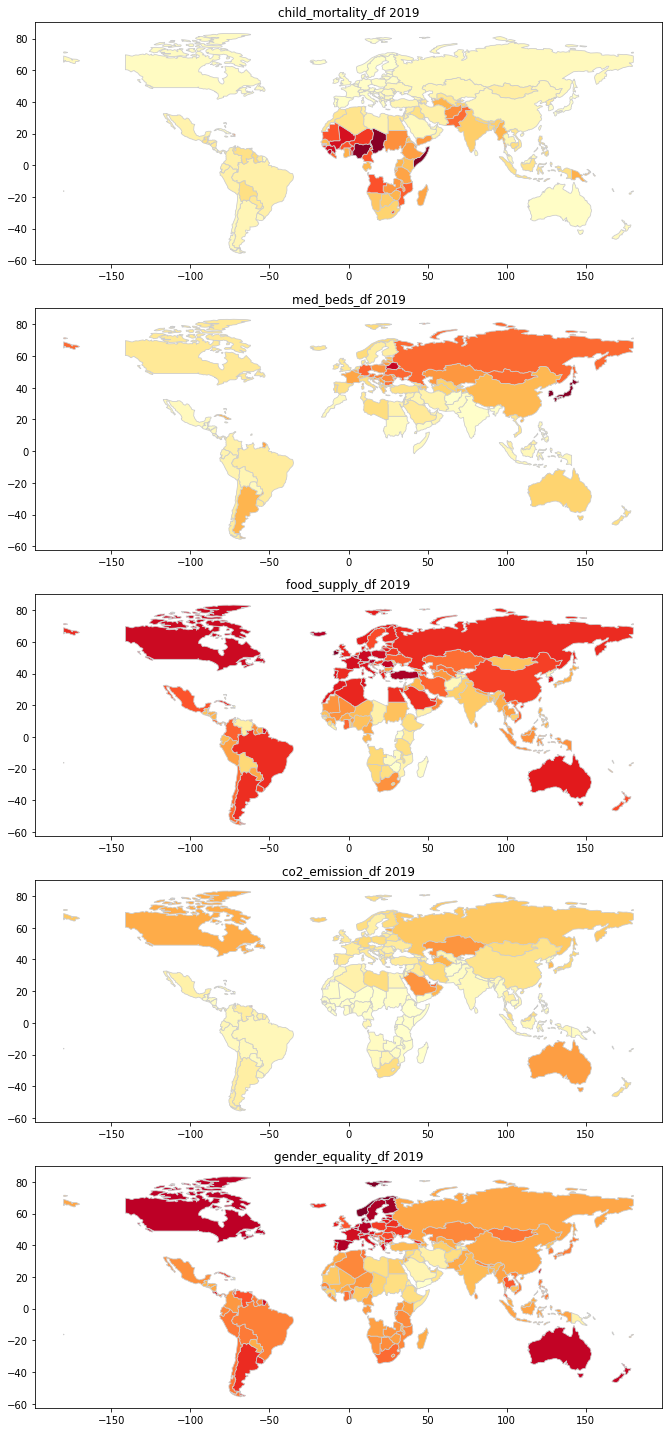

In [50]:
plot_global_map_subplot(df_list=[child_mortality_df, med_beds_df, food_supply_df, co2_emission_df, gender_equality_df], year=2019)

# Data correlation analysis

In [51]:
dataframes = {
    'child_mortality': child_mortality_df,
    'food_supply': food_supply_df,
    'med_beds': med_beds_df,
    'co2_emission': co2_emission_df,
    'gender_equality': gender_equality_df
}

for name, df in dataframes.items():
    df.rename(columns={'2019': name}, inplace=True)
merged_df = child_mortality_df[['country']].copy()

for name, df in dataframes.items():
    merged_df = merged_df.merge(df[['country', name]], on='country')


In [52]:
correlations = merged_df.iloc[:, 1:].corrwith(merged_df['child_mortality'])
print(correlations)

child_mortality    1.000000
food_supply       -0.685425
med_beds          -0.431678
co2_emission      -0.350444
gender_equality   -0.624504
dtype: float64


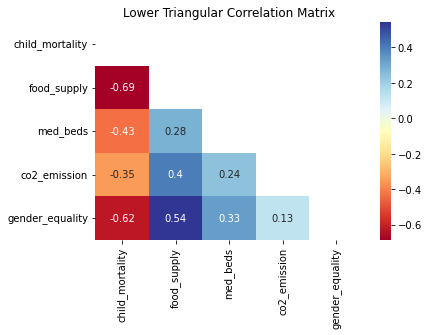

In [53]:
correlation_matrix = merged_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, mask=mask, annot=True, cmap='RdYlBu')
plt.title('Lower Triangular Correlation Matrix')
plt.show()

An inverse correlation has been detected between the variables and the "child_mortality" indicator with a value greater than -0.35, indicating that as the values increase, the "child_mortality" indicator decreases. However, the variable "child_mortality" is also mutually correlated with other variables when the value is less than 0.41. For an optimal model, the explanatory variables should have weak correlation among themselves but a strong correlation with the variable we want to predict.

In [54]:
country_corr = pd.DataFrame()
country_corr['country'] = merged_df['country']
country_corr['2019'] = merged_df.iloc[:, 1:].apply(lambda row: sum(abs(row - row.mean())), axis=1)

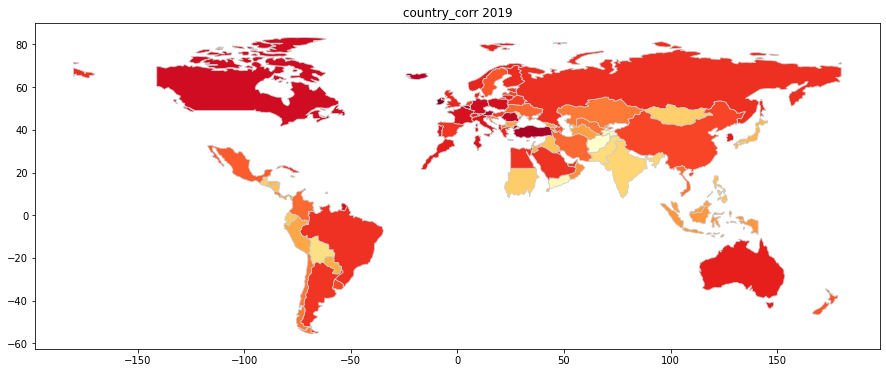

In [55]:
plot_global_map(df=country_corr, year=2019)

In [56]:
merged_df.to_csv('./analysis_data/analysis_data.csv')

## Data standardization

In [57]:
def standardize(df: pd.DataFrame):
    normalized_df = pd.DataFrame()
    normalized_df[df.columns[0:2]] = df[df.columns[0:2]]
    normalized_df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x - x.mean() / (x.std()))
    return normalized_df

norm_merged_df = standardize(merged_df)
norm_merged_df['child_mortality'] = norm_merged_df['child_mortality'].astype('uint64')
norm_merged_df

,country,child_mortality,food_supply,med_beds,co2_emission,gender_equality
0,Afghanistan,60,2031.935887,-1.004366,-0.854632,30.437688
1,Albania,8,3386.935887,1.455634,0.481368,58.637688
2,United Arab Emirates,7,3276.935887,-0.014366,20.291368,37.737688
3,Argentina,9,3301.935887,3.695634,3.301368,71.937688
4,Armenia,12,3033.935887,2.955634,0.781368,54.137688
...,...,...,...,...,...,...
93,Uruguay,7,3212.935887,0.805634,0.865010,72.337688
94,United States,6,3764.935887,1.405634,15.230256,70.737688
95,Uzbekistan,20,3036.935887,2.445634,1.584701,46.037688
96,Vietnam,20,3064.935887,1.225634,1.134979,56.537688


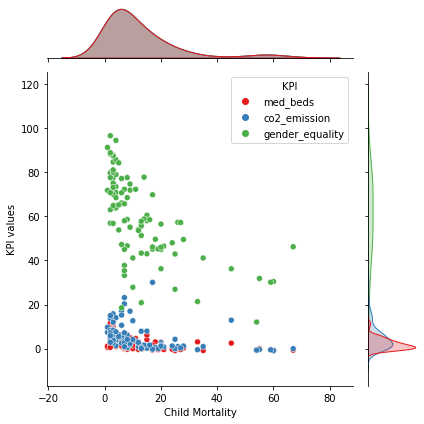

In [58]:
merged_df_melted = pd.melt(norm_merged_df, id_vars='child_mortality', value_vars=['med_beds', 'co2_emission', 'gender_equality'], var_name='KPI')

g = sns.jointplot(data=merged_df_melted, x='child_mortality', y='value', hue='KPI', palette='Set1', kind='scatter')
g.set_axis_labels('Child Mortality', 'KPI values')
# g.ax_joint.set_yscale('log')
plt.tight_layout()
plt.show()

In [59]:
norm_merged_df.to_csv('./analysis_data/analysis_data_normalized.csv')